"""
BUSINESS PROBLEM:
- Company experiences customer churn
- Need to understand WHO churns, WHEN churn happens, and WHICH segment is most at risk

BUSINESS GOAL:
- Identify high-risk customer segments
- Determine critical churn timing
- Support data-driven retention strategy
"""

# STEP 0 – Import Library

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# STEP 1 – Load & merge data 

In [3]:
# Load datasets
status_analysis = pd.read_csv("D:\\TakeHomeTest\\DA\dataset\\Status_Analysis.csv")
service_options = pd.read_csv("D:\\TakeHomeTest\\DA\\dataset\\Service_Options.csv")
online_services = pd.read_csv("D:\\TakeHomeTest\\DA\\dataset\\Online_Services.csv")
payment_info = pd.read_csv("D:\\TakeHomeTest\\DA\dataset\\Payment_Info.csv")
location_data = pd.read_csv("D:\\TakeHomeTest\\DA\\dataset\\Location_Data.csv")
customer_info = pd.read_csv("D:\\TakeHomeTest\\DA\\dataset\\Customer_Info.csv")

In [4]:
# Merge datasets on customer_id
df = status_analysis.merge(service_options, on='customer_id')
df = df.merge(online_services, on='customer_id')
df = df.merge(payment_info, on='customer_id')
df = df.merge(location_data, on='customer_id')
df = df.merge(customer_info, on='customer_id')

In [5]:
df = df.copy()

print(df.shape)
df.head()

(7043, 53)


,customer_id,satisfaction_score,cltv,customer_status,churn_score,churn_label,churn_value,churn_category,churn_reason,tenure,internet_service_x,phone_service_x,multiple_lines,avg_monthly_gb_download,unlimited_data,offer,referred_a_friend,number_of_referrals,phone_service_y,internet_service_y,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,internet_type,contract,paperless_billing,payment_method,monthly_ charges,avg_monthly_long_distance_charges,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,country,state,city,zip_code,total_population,latitude,longitude,gender,age,under_30,senior_citizen,partner,dependents,number_of_dependents,married
0,0002-ORFBO,3,2205,Stayed,65,No,0,Not Applicable,NaN,9,Yes,Yes,No,16,Yes,NaN,Yes,2,Yes,Yes,No,Yes,No,Yes,Yes,No,No,Cable,One Year,Yes,Mailed check,65.6,42.39,593.30,0.00,0,381.51,974.81,United States,California,Frazier Park,93225,4498,34.827662,-118.999073,Female,37,No,No,Yes,No,0,Yes
1,0003-MKNFE,5,5414,Stayed,66,No,0,Not Applicable,NaN,9,Yes,Yes,Yes,10,No,NaN,No,0,Yes,Yes,No,No,No,No,No,Yes,Yes,Cable,Month-to-Month,No,Mailed check,59.9,10.69,542.40,38.33,10,96.21,610.28,United States,California,Glendale,91206,31297,34.162515,-118.203869,Male,46,No,No,No,No,0,No
2,0004-TLHLJ,1,4479,Churned,71,Yes,1,Competitor,Competitor had better devices,4,Yes,Yes,No,30,Yes,Offer E,No,0,Yes,Yes,No,No,Yes,No,No,No,No,Fiber Optic,Month-to-Month,Yes,Electronic check,73.9,33.65,280.85,0.00,0,134.60,415.45,United States,California,Costa Mesa,92627,62069,33.645672,-117.922613,Male,50,No,No,No,No,0,No
3,0011-IGKFF,1,3714,Churned,91,Yes,1,Dissatisfaction,Product dissatisfaction,13,Yes,Yes,No,4,Yes,Offer D,Yes,1,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Fiber Optic,Month-to-Month,Yes,Electronic check,98.0,27.82,1237.85,0.00,0,361.66,1599.51,United States,California,Martinez,94553,46677,38.014457,-122.115432,Male,78,No,Yes,Yes,No,0,Yes
4,0013-EXCHZ,1,3464,Churned,68,Yes,1,Dissatisfaction,Network reliability,3,Yes,Yes,No,11,Yes,NaN,Yes,3,Yes,Yes,No,No,No,Yes,Yes,No,No,Fiber Optic,Month-to-Month,Yes,Mailed check,83.9,7.38,267.40,0.00,0,22.14,289.54,United States,California,Camarillo,93010,42853,34.227846,-119.079903,Female,75,No,Yes,Yes,No,0,Yes


# STEP 2 – Data Understanding & Missing Values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 53 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   customer_id                        7043 non-null   object 
 1   satisfaction_score                 7043 non-null   int64  
 2   cltv                               7043 non-null   int64  
 3   customer_status                    7043 non-null   object 
 4   churn_score                        7043 non-null   int64  
 5   churn_label                        7043 non-null   object 
 6   churn_value                        7043 non-null   int64  
 7   churn_category                     7043 non-null   object 
 8   churn_reason                       1869 non-null   object 
 9   tenure                             7043 non-null   int64  
 10  internet_service_x                 7043 non-null   object 
 11  phone_service_x                    7043 non-null   objec

In [7]:
df.isna().sum().sort_values(ascending=False)

churn_reason                         5174
offer                                3877
internet_type                        1526
satisfaction_score                      0
cltv                                    0
churn_score                             0
customer_status                         0
churn_value                             0
churn_label                             0
tenure                                  0
internet_service_x                      0
phone_service_x                         0
churn_category                          0
multiple_lines                          0
avg_monthly_gb_download                 0
unlimited_data                          0
referred_a_friend                       0
number_of_referrals                     0
phone_service_y                         0
internet_service_y                      0
customer_id                             0
online_security                         0
online_backup                           0
premium_tech_support              

# STEP 3 – DATA CLEANING

## 3.1 Rename column typo

In [8]:
df.rename(columns={'monthly_ charges': 'monthly_charges'}, inplace=True)

## 3.2 Check duplicates

In [9]:
df.duplicated().sum()

np.int64(0)

# STEP 4 – EXPLORATORY DATA ANALYSIS (EDA)

## 4.1 Target Variable (Churn)

In [10]:
df['churn_value'].value_counts(normalize=True)

churn_value
0    0.73463
1    0.26537
Name: proportion, dtype: float64

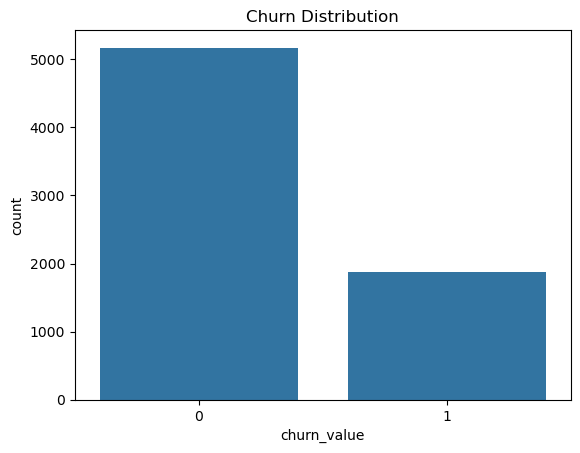

In [11]:
sns.countplot(x='churn_value', data=df)
plt.title('Churn Distribution')
plt.show()

Mayoritas pelanggan masih bertahan, tetapi tingkat churn cukup signifikan (±26%)

## 4.2 Tenure vs Churn

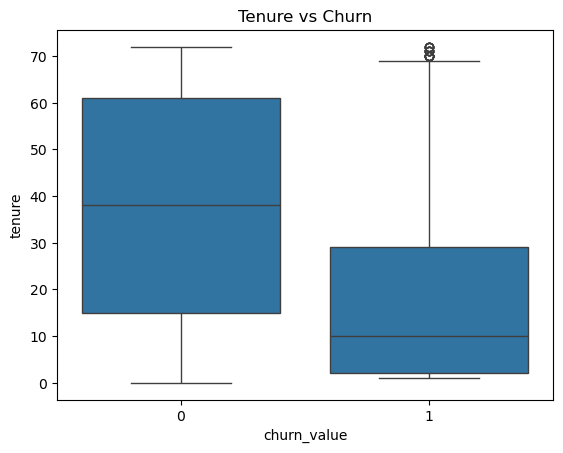

In [12]:
sns.boxplot(x='churn_value', y='tenure', data=df)
plt.title('Tenure vs Churn')
plt.show()

**Tenure pelanggan yang churn jauh lebih rendah dibandingkan yang tidak churn.**
Ini menunjukkan bahwa **pelanggan baru memiliki risiko churn lebih tinggi**, sehingga upaya retensi perlu difokuskan pada fase awal berlangganan.

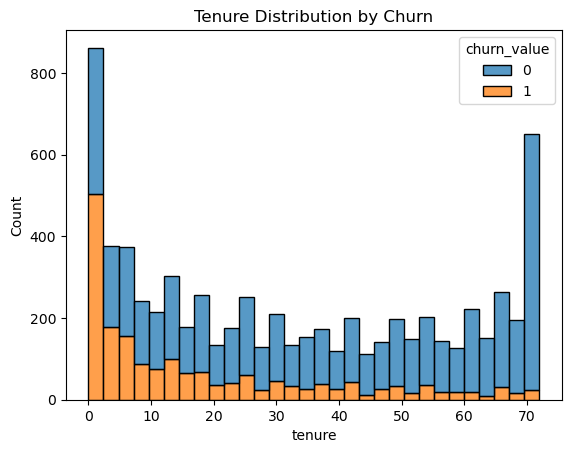

In [13]:
sns.histplot(
    data=df,
    x='tenure',
    hue='churn_value',
    bins=30,
    multiple='stack'
)
plt.title('Tenure Distribution by Churn')
plt.show()

**Pelanggan dengan tenure 0–3 bulan memiliki tingkat churn paling tinggi**, menunjukkan bahwa periode awal berlangganan merupakan fase paling kritis dalam mempertahankan pelanggan. Strategi onboarding dan early retention sangat diperlukan pada rentang waktu ini.

## 4.3 Financial Analysis

In [14]:
# Average monthly charges
df.groupby('churn_label')['monthly_charges'].mean()

churn_label
No     61.265124
Yes    74.441332
Name: monthly_charges, dtype: float64

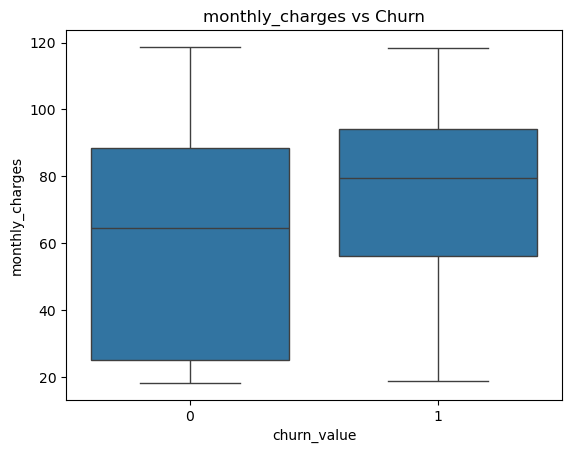

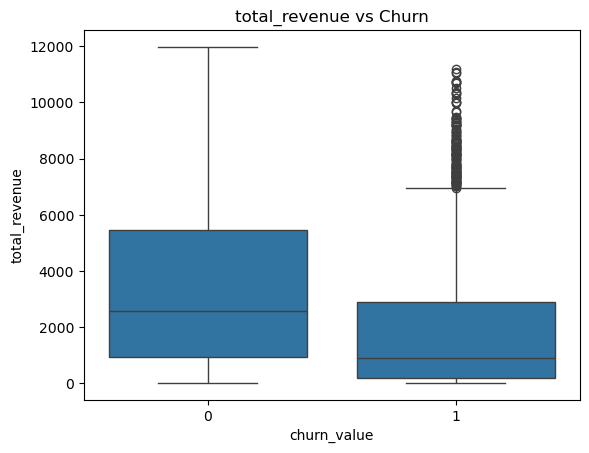

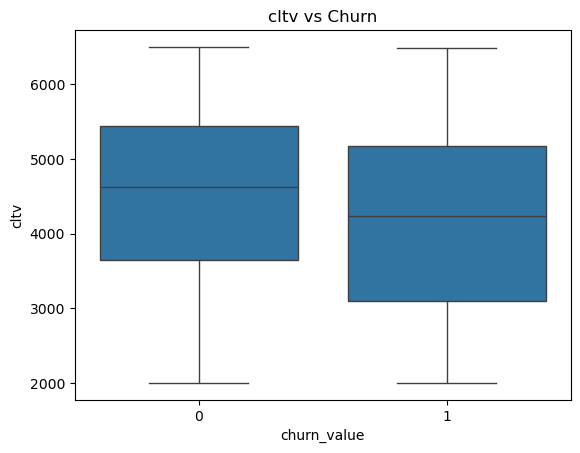

In [15]:
financial_cols = ['monthly_charges', 'total_revenue', 'cltv']

for col in financial_cols:
    sns.boxplot(x='churn_value', y=col, data=df)
    plt.title(f'{col} vs Churn')
    plt.show()

- Pada pelanggan tidak churn, Q1 ≈ 25, median ≈ 65, dan Q3 ≈ 90, sedangkan pada pelanggan churn, Q1 ≈ 58, median ≈ 80, dan Q3 ≈ 93. **Hal ini mengindikasikan bahwa semakin tinggi monthly charges, semakin besar risiko churn.**
- Pelanggan tidak churn memiliki total revenue yang jauh lebih tinggi (Q1 ≈ 1.000, median ≈ 2.500, Q3 ≈ 5.700) dibandingkan pelanggan churn (Q1 ≈ 100, median ≈ 1.000, Q3 ≈ 2.600). **Hal ini menegaskan bahwa pelanggan yang churn umumnya memberikan kontribusi pendapatan lebih rendah**
- Pada pelanggan tidak churn, Q1 ≈ 3.600, median ≈ 4.600, dan Q3 ≈ 5.400, sedangkan pada pelanggan churn, Q1 ≈ 3.100, median ≈ 4.300, dan Q3 ≈ 5.100.
Hal ini mengindikasikan bahwa **pelanggan dengan CLTV lebih rendah memiliki kecenderungan churn lebih besar**

## 4.4 Behavioral Analysis

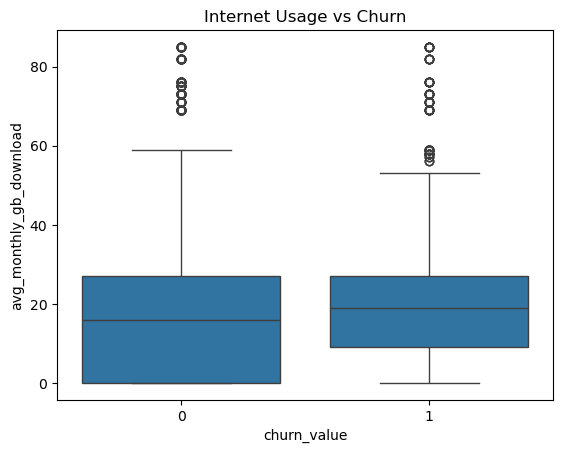

In [16]:
sns.boxplot(
    x='churn_value',
    y='avg_monthly_gb_download',
    data=df
)
plt.title('Internet Usage vs Churn')
plt.show()

Pelanggan yang **churn (1)** memiliki **median penggunaan internet bulanan yang sedikit lebih tinggi dibandingkan pelanggan tidak churn (0).**
Penggunaan internet yang lebih tinggi berkorelasi dengan **risiko churn yang sedikit lebih besar**, tetapi bukan satu-satunya faktor penentu

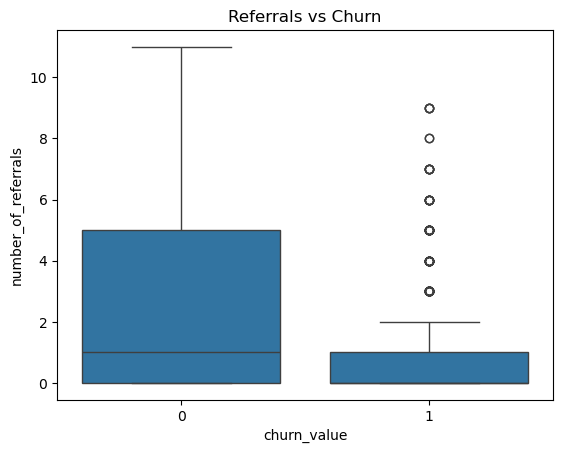

In [17]:
sns.boxplot(
    x='churn_value',
    y='number_of_referrals',
    data=df
)
plt.title('Referrals vs Churn')
plt.show()

Pelanggan tidak churn (0) memiliki jumlah referral yang lebih tinggi dibandingkan pelanggan churn (1), terlihat dari median dan sebaran data yang lebih besar. **Semakin banyak referral yang dilakukan pelanggan, semakin kecil kemungkinan pelanggan melakukan churn**, sehingga referral dapat menjadi indikator loyalitas pelanggan.

## 4.5 Service Adoption vs Churn

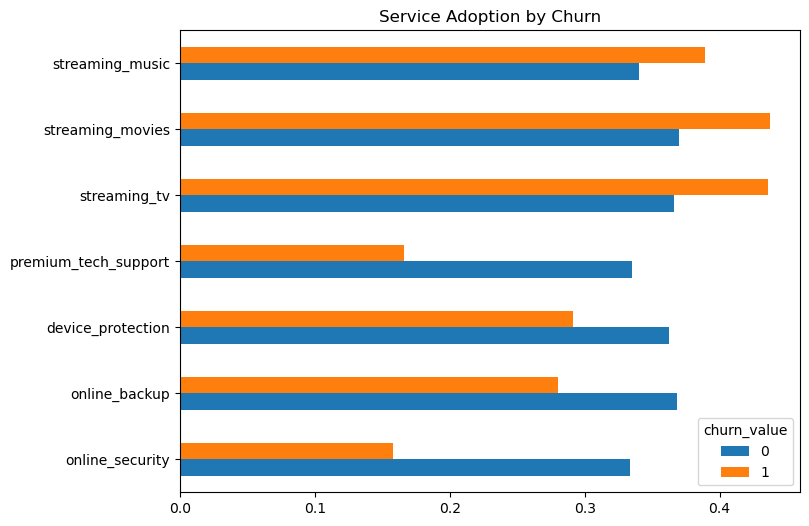

In [21]:
service_cols = [
    'online_security','online_backup','device_protection',
    'premium_tech_support','streaming_tv',
    'streaming_movies','streaming_music'
]

service_summary = (
    df.groupby('churn_value')[service_cols]
      .apply(lambda x: (x == 'Yes').mean())
      .T
)

service_summary.plot(kind='barh', figsize=(8,6))
plt.title('Service Adoption by Churn')
plt.show()

In [22]:
print((service_summary * 100).round(2))

churn_value               0      1
online_security       33.32  15.78
online_backup         36.84  27.98
device_protection     36.28  29.16
premium_tech_support  33.51  16.59
streaming_tv          36.59  43.55
streaming_movies      36.99  43.77
streaming_music       34.02  38.95


Pelanggan yang tidak menggunakan layanan tambahan cenderung memiliki risiko churn jauh lebih tinggi. Layanan seperti online security dan premium tech support terbukti paling efektif dalam menurunkan churn.

Layanan keamanan dan dukungan teknis berperan penting dalam menekan churn, sedangkan layanan streaming tidak secara efektif meningkatkan loyalitas pelanggan.

## 4.6 Behavioral Analysis (Engagement)

In [23]:
summary = (
    df.groupby('churn_label')
      .agg(
          avg_satisfaction=('satisfaction_score','mean'),
          customers=('customer_id','count')
      )
)

summary['percentage'] = summary['customers'] / summary['customers'].sum() * 100
summary

,avg_satisfaction,customers,percentage
churn_label,,,
No,3.789911,5174,73.463013
Yes,1.736223,1869,26.536987


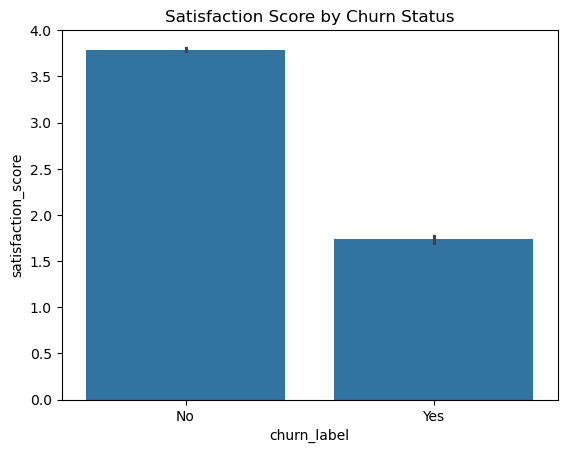

In [24]:
df.groupby('churn_label')['satisfaction_score'].mean()
sns.barplot(
    x='churn_label',
    y='satisfaction_score',
    data=df,
    estimator=np.mean
)
plt.title('Satisfaction Score by Churn Status')
plt.show()

Pelanggan **tidak churn (No)** memiliki **rata-rata tingkat kepuasan yang jauh lebih tinggi (3,79)** dibandingkan pelanggan **churn (Yes)** yang hanya sebesar **1,74.**

Sebanyak 73,46% pelanggan tidak churn, sedangkan 26,54% pelanggan churn.
**Tingkat kepuasan pelanggan berpengaruh kuat terhadap churn**, semakin rendah kepuasan semakin besar kemungkinan pelanggan berhenti berlangganan.

## 4.8 Contrac type vc Churn

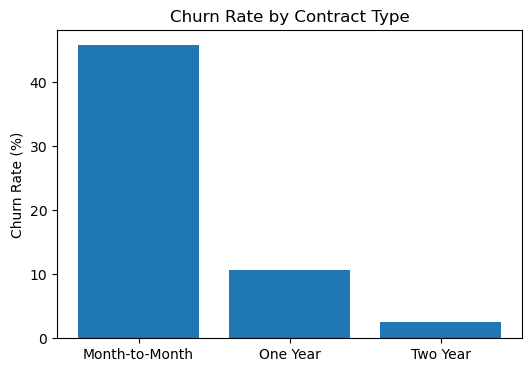

In [25]:
churn_contract = (
    df.groupby('contract')['churn_label']
      .apply(lambda x: (x == 'Yes').mean() * 100)
      .reset_index(name='churn_rate')
      .sort_values('churn_rate', ascending=False)
)

churn_contract
plt.figure(figsize=(6,4))
plt.bar(churn_contract['contract'], churn_contract['churn_rate'])
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate (%)')
plt.show()

In [26]:
print("\n=== Churn Rate by Contract Type (%) ===")
print(churn_contract.round(2))


=== Churn Rate by Contract Type (%) ===
         contract  churn_rate
0  Month-to-Month       45.84
1        One Year       10.71
2        Two Year        2.55


Semakin panjang durasi kontrak, semakin rendah risiko churn, sehingga mendorong pelanggan beralih ke kontrak jangka panjang merupakan strategi efektif untuk meningkatkan retensi.

## 4.8 Churn Reason (Churners Only)

In [17]:
df[df['churn_value'] == 1]['churn_reason'].value_counts().head(10)

churn_reason
Competitor had better devices                313
Competitor made better offer                 311
Attitude of support person                   220
Don't know                                   130
Competitor offered more data                 117
Competitor offered higher download speeds    100
Attitude of service provider                  94
Price too high                                78
Product dissatisfaction                       77
Network reliability                           72
Name: count, dtype: int64

# STEP 5 – FEATURE ENGINEERING (SEGMENTATION)

In [28]:
# Total streaming services
df['num_streaming_services'] = (
    (df['streaming_tv'] == 'Yes').astype(int) +
    (df['streaming_movies'] == 'Yes').astype(int) +
    (df['streaming_music'] == 'Yes').astype(int)
)

# Security service
df['has_security_service'] = (
    (df['online_security'] == 'Yes') |
    (df['online_backup'] == 'Yes') |
    (df['device_protection'] == 'Yes')
).astype(int)

# Total services used
df['total_services_used'] = (
    df[service_cols] == 'Yes'
).sum(axis=1)

# STEP 6 – CUSTOMER SEGMENTATION (K-MEANS)

## 6.1 Feature Selection

In [29]:
seg_features = [
    'tenure',
    'monthly_charges',
    'total_revenue',
    'cltv',
    'avg_monthly_gb_download',
    'total_services_used'
]

X = df[seg_features]

## 6.2 Feature Scaling

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 6.3 Elbow Method

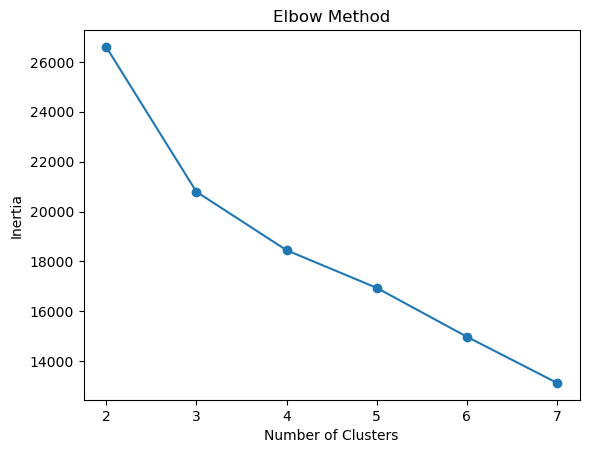

In [31]:
inertia = []

for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2, 8), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

## 6.4 Silhouette Score

In [32]:
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f'k={k}, silhouette={score:.3f}')

k=2, silhouette=0.334
k=3, silhouette=0.290
k=4, silhouette=0.274
k=5, silhouette=0.227


Meskipun k = 2 memiliki silhouette score tertinggi (0,334), k = 3 dipilih karena lebih mudah diinterpretasikan dan lebih relevan secara bisnis. Dengan tiga cluster, pelanggan dapat dikelompokkan menjadi segmen yang lebih bermakna (misalnya low, medium, dan high value / low–medium–high risk churn), sehingga strategi pemasaran dan retensi dapat dibuat lebih spesifik dan actionable.

Pemilihan k = 3 merupakan kompromi yang tepat antara kualitas clustering dan kegunaan bisnis.

## 6.5 Fit Final Model

In [33]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

## 6.6 Cluster Profiling

In [34]:
cluster_profile = (
    df.groupby('cluster')
      .agg(
          customers=('customer_id', 'count'),
          avg_tenure=('tenure', 'mean'),
          avg_revenue=('total_revenue', 'mean'),
          avg_cltv=('cltv', 'mean'),
          churn_rate=('churn_value', 'mean')
      )
)

cluster_profile

,customers,avg_tenure,avg_revenue,avg_cltv,churn_rate
cluster,,,,,
0,2005,27.803491,1343.826244,4435.745137,0.136658
1,2150,58.826977,6664.778879,5111.605116,0.145581
2,2888,15.846953,1505.362008,3846.143698,0.443906


Cluster 1 adalah aset utama perusahaan, sementara Cluster 2 adalah prioritas utama penanganan churn.

# STEP 7 – COHORT ANALYSIS

## 7.1 Tenure Cohort

In [35]:
df['tenure_cohort'] = pd.cut(
    df['tenure'],
    bins=[0,3,6,12,24,100],
    labels=['0–3','4–6','7–12','13–24','25+']
)

## 7.2 Cohort Metrics

In [36]:
cohort_summary = (
    df.groupby('tenure_cohort')
      .agg(
          customers=('customer_id','count'),
          churn_rate=('churn_value','mean'),
          avg_revenue=('total_revenue','mean'),
          avg_cltv=('cltv','mean')
      )
)

cohort_summary

,customers,churn_rate,avg_revenue,avg_cltv
tenure_cohort,,,,
0–3,1051,0.568030,126.642141,4047.515699
4–6,419,0.446301,395.529737,4014.758950
7–12,705,0.358865,769.323660,4038.127660
13–24,1024,0.287109,1560.117500,4015.195312
25+,3833,0.140360,4937.543960,4710.774589


Churn rate **menurun tajam seiring bertambahnya tenure pelanggan.**
Pelanggan **0–3** bulan memiliki churn rate tertinggi **(56,8%)** dengan revenue terendah, sedangkan pelanggan **25+** bulan memiliki churn rate terendah **(14,0%)*8 serta **rata-rata revenue dan CLTV tertinggi.**

## 7.3 Cohort Heatmap (Churn)

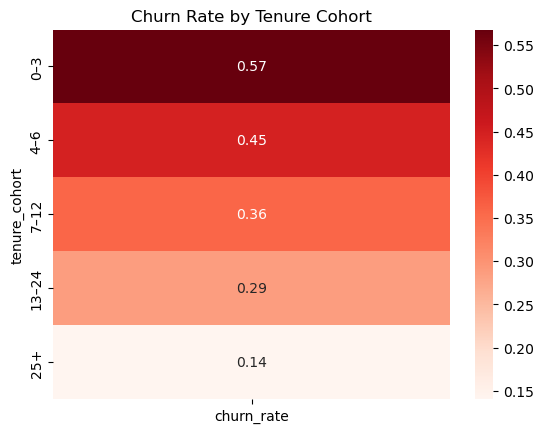

In [37]:
sns.heatmap(
    cohort_summary[['churn_rate']],
    annot=True,
    cmap='Reds'
)
plt.title('Churn Rate by Tenure Cohort')
plt.show()

Masa awal berlangganan adalah fase paling kritis churn, sementara pelanggan jangka panjang merupakan kontributor nilai terbesar dan paling loyal.

# STEP 8 – COMBINE COHORT + SEGMENTATION

In [38]:
combo_analysis = (
    df.groupby(['cluster','tenure_cohort'])
      .agg(
          customers=('customer_id','count'),
          churn_rate=('churn_value','mean'),
          avg_revenue=('total_revenue','mean')
      )
      .reset_index()
)

combo_analysis

,cluster,tenure_cohort,customers,churn_rate,avg_revenue
0,0,0–3,401,0.386534,71.167756
1,0,4–6,125,0.200000,238.444480
2,0,7–12,227,0.149780,462.235022
3,0,13–24,316,0.085443,944.660854
4,0,25+,930,0.035484,2397.566204
5,1,0–3,0,NaN,NaN
6,1,4–6,0,NaN,NaN
7,1,7–12,0,NaN,NaN
8,1,13–24,6,0.500000,3159.333333
9,1,25+,2144,0.144590,6674.588895


**Cluster 0 (Stabil Bertumbuh)**

Terlihat pola yang sangat jelas: semakin lama tenure, semakin rendah churn rate (dari 38,7% di 0–3 bulan menjadi hanya 3,5% di 25+ bulan), seiring dengan kenaikan revenue yang konsisten. Ini menunjukkan efektivitas retensi jangka panjang pada cluster ini.

**Cluster 1 (High Value Loyal)**

Hampir seluruh pelanggan berada pada tenure 25+ bulan dengan churn rate relatif rendah (14,5%) dan average revenue tertinggi. Cluster ini merepresentasikan pelanggan paling matang dan bernilai tinggi.

**Cluster 2 (High Risk Churn)**

Memiliki churn rate sangat tinggi di semua tenure, terutama pada fase awal (68% pada 0–3 bulan). Meskipun churn menurun seiring tenure bertambah, nilainya tetap tinggi bahkan pada 25+ bulan (25,7%). Revenue meningkat, tetapi tidak cukup menekan risiko churn.

## Heatmap: Cluster × Cohort Churn

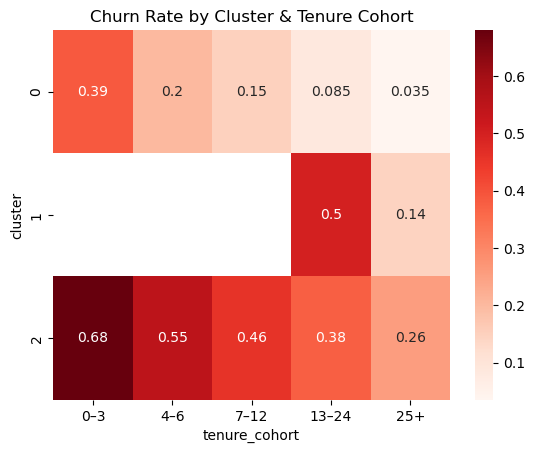

In [39]:
pivot_churn = combo_analysis.pivot(
    index='cluster',
    columns='tenure_cohort',
    values='churn_rate'
)

sns.heatmap(pivot_churn, annot=True, cmap='Reds')
plt.title('Churn Rate by Cluster & Tenure Cohort')
plt.show()

Cluster 2 membutuhkan intervensi agresif sejak awal, Cluster 0 menunjukkan jalur pertumbuhan yang sehat, dan Cluster 1 adalah aset utama yang harus dipertahankan.

# STEP 9 — Churn Driver Analysis

## 9.1 Churn Rate by Key Drivers

### 9.1.1 Contract Type

In [41]:
churn_by_contract = (
    df.groupby('contract')['churn_value']
      .mean()
      .sort_values(ascending=False)
      .reset_index(name='churn_rate')
)

churn_by_contract

,contract,churn_rate
0,Month-to-Month,0.458449
1,One Year,0.107097
2,Two Year,0.025491


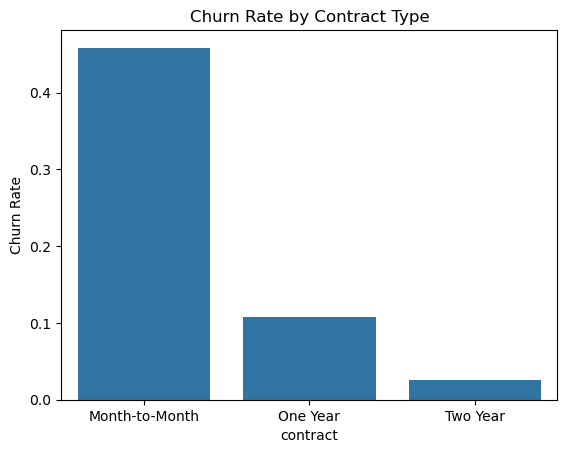

In [42]:
sns.barplot(
    data=churn_by_contract,
    x='contract',
    y='churn_rate'
)
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate')
plt.show()

Kontrak jangka pendek merupakan faktor risiko utama churn, sedangkan kontrak jangka panjang sangat efektif dalam menekan churn. Strategi konversi pelanggan ke kontrak 1–2 tahun akan berdampak signifikan pada retensi.

### 9.1.2 Payment Method

In [43]:
churn_by_payment = (
    df.groupby('payment_method')['churn_value']
      .mean()
      .sort_values(ascending=False)
      .reset_index(name='churn_rate')
)

churn_by_payment

,payment_method,churn_rate
0,Electronic check,0.452854
1,Mailed check,0.191067
2,Bank transfer (automatic),0.167098
3,Credit card (automatic),0.152431


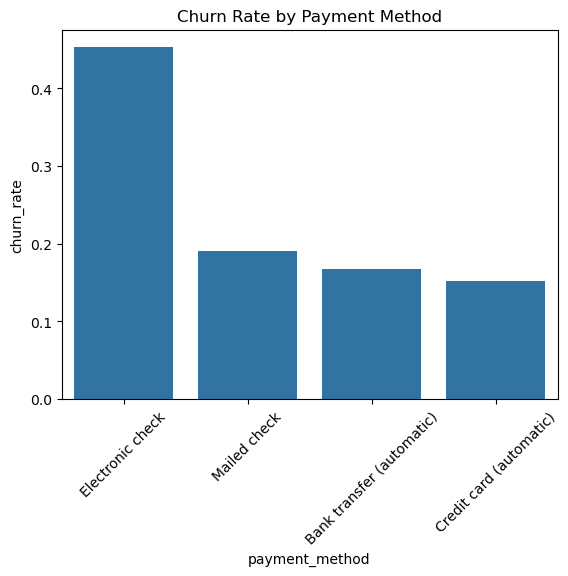

In [44]:
sns.barplot(
    data=churn_by_payment,
    x='payment_method',
    y='churn_rate'
)
plt.xticks(rotation=45)
plt.title('Churn Rate by Payment Method')
plt.show()

Pelanggan yang menggunakan Electronic check memiliki churn rate paling tinggi (45,29%), jauh dibandingkan metode pembayaran otomatis seperti Credit card (15,24%) dan Bank transfer (16,71%).

# STEP 10 - Early Churn Analysis

## 10.1 Define Early Churn

In [45]:
df['early_churn'] = np.where(
    (df['tenure'] <= 3) & (df['churn_value'] == 1),
    1, 0
)

df['early_churn'].mean()

np.float64(0.08476501490841971)

### 10.1.1 Early Churn by Contract

In [46]:
early_churn_contract = (
    df[df['tenure'] <= 3]
    .groupby('contract')['churn_value']
    .mean()
    .reset_index(name='early_churn_rate')
)

early_churn_contract

,contract,early_churn_rate
0,Month-to-Month,0.593220
1,One Year,0.074074
2,Two Year,0.000000


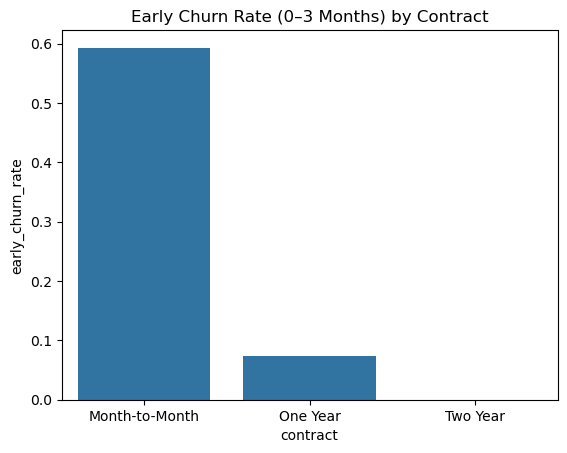

In [47]:
sns.barplot(
    data=early_churn_contract,
    x='contract',
    y='early_churn_rate'
)
plt.title('Early Churn Rate (0–3 Months) by Contract')
plt.show()

# STEP 11 — Revenue Impact Analysis

## 11.1 Total Revenue Lost

In [48]:
total_revenue_lost = df.loc[df['churn_value'] == 1, 'total_revenue'].sum()
total_revenue_lost

np.float64(3684459.8200000003)

## Revenue Lost by Cluster

In [49]:
revenue_lost_cluster = (
    df[df['churn_value'] == 1]
    .groupby('cluster')['total_revenue']
    .sum()
    .reset_index(name='revenue_lost')
)

revenue_lost_cluster

,cluster,revenue_lost
0,0,129344.87
1,1,2030858.08
2,2,1524256.87


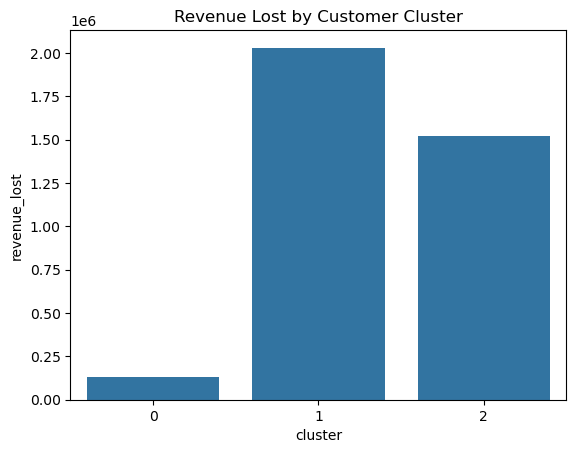

In [50]:
sns.barplot(
    data=revenue_lost_cluster,
    x='cluster',
    y='revenue_lost'
)
plt.title('Revenue Lost by Customer Cluster')
plt.show()